For this project my goal was to take a previous tool box that I created from a previous GIS class and turn it into code.  Down below is a general workflow that I used for this project.  I added an additional couple steps that include creating a buffer around the rivers.  The reasoning for this was to use this buffer to determine the vegetation around a stream where more process could occur.


With this project I hope to find an answer to what the NDVI around the streams looks like to see if this methodology is accurate.  Doing this can be helpful in the future for future anaylsis on stream areas.  

This project was completed in ArcGIS Pro 2.7, using the arcpy module system which does contain many of the same environments that had been used in the class previously.  I chose to use this for ease of access and so I do not have to worry about switching between conda environments and Arc pros. The other large reason why I chose to use this software was because of the need to use some of the tools for finding flow directions and stream defintions, there is most likely a way to to this with more open source material. For the data, I used a DEM of a granule of Idaho that was found on NASA earth data explorer.  The bands for the composite was from USGS earth explorer.  With these two sets of data I was able to accomplish my goal for the project.

From the NDVI results it does seem that it was pretty accurate in finding that there was live vegetation around most streams, so for the moment it does seem that my methodology works.  Granted the composite data could have been better or be observed from different times to see what the difference in NDVI values are.  

Some issues I had with this project are that ArcGIS sometimes does not like to save notebooks or deletes them from unknown reasons.  Other times when troubleshooting code there would be some instances where I would be thrown and error just to run the same code again and for it work.  

For the future I would like to compare my results to other maps to see if my methodlogy was correct in finding streams, or if watersheds differ.  It would also be interesting to use different DEMs over a time to see how they change. 

**Work Flow**

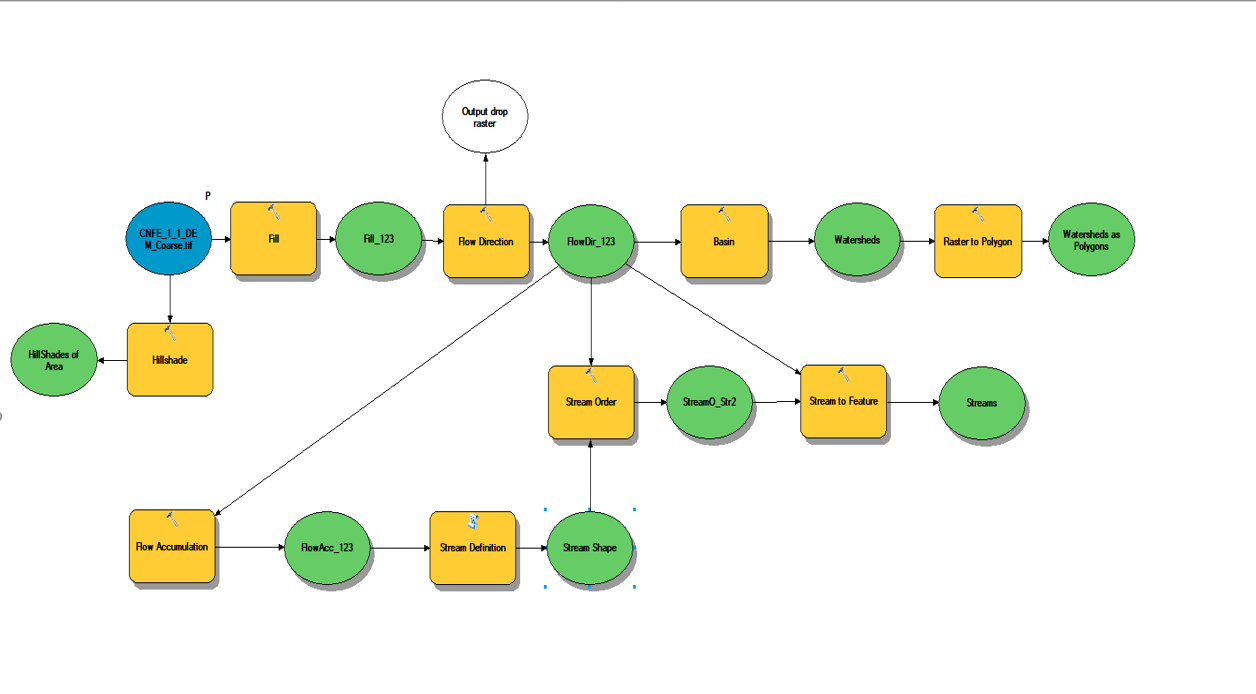

In [1]:
import arcpy
from arcpy import env
from arcpy.sa import *
env.workspace = 'C:/project_479'

**FILL**  - This is the first step in the workflow where a DEM is used.  For this project I am using a granule of Idaho taht was collected using ASTER 2.  The data was then downloaded from NASA Earth Data.

In [2]:
outFill = Fill('ASTGTMV003_N44W116_dem.tif')
outFill.save('C:/project_479/fill1')

**Flow Direction** - This next step is to create a flow direction that takes the Fill raster and determines the ways that water could flow.

In [3]:
dropraster  = "C:/project_479/dropraster"
outFlow = FlowDirection(outFill,'NORMAL',dropraster)
outFlow.save('C:/project_479/n44_direction')

**Basin** - this next step is to just gather the size/shape of the watershed still as a raster.

In [4]:
outBasin = Basin(outFlow)
outBasin.save("C:/project_479/outbasin2")

**Raster to Polygon** - This is what turns the Basin raster to a polygon.

In [5]:
value = 'VALUE'
arcpy.RasterToPolygon_conversion(outBasin, "C:/project_479/watersheds.shp", "NO_SIMPLIFY",value)

<Result 'C:\\project_479\\watersheds.shp'>

**Flow accumulation** - this next step is what determines the general amount of water that would collected in lower points of the DEM.

In [6]:
outFlowAcc = FlowAccumulation(outFlow)
outFlowAcc.save("C:/project_479/n44_flowAcc")

**Stream Order** - This one creates the order of water collection in raster cells.

In [7]:
outStreamOrder = StreamOrder(outFlowAcc, outFlow, 'STRAHLER')
outStreamOrder.save('C:/project_479/streamorder1')

**Stream to Feature** - takes the previous raster and creates a vector of the streams.

Adjustment of the data.

In [8]:
outSetNull = SetNull(outStreamOrder, '1', 'VALUE < 7')
outSetNull.save('C:/project_479/outsetnull')

In [9]:
StreamToFeature(outSetNull, outFlow, 'C:/project_479/streams_N44_test.shp', 'SIMPLIFY')

<geoprocessing server result object object at 0x00000195CA510630>

**Buffer** - Once the stream feature class is created a buffer is then applied to stream network.

In [10]:
arcpy.Buffer_analysis('streams_n44_test.shp', 'C:/project_479/bufferStream', '100 feet', "FULL", 'ROUND')

<Result 'C:\\project_479\\bufferStream.shp'>

**Composite Bands**

In [11]:
arcpy.CompositeBands_management('LC08_L2SP_041029_20180628_20200831_02_T1_SR_B5.TIF;LC08_L2SP_041029_20180628_20200831_02_T1_SR_B4.TIF;LC08_L2SP_041029_20180628_20200831_02_T1_SR_B3.TIF;LC08_L2SP_041029_20180628_20200831_02_T1_SR_B2.TIF;LC08_L2SP_041029_20180628_20200831_02_T1_SR_B1.TIF',
                                'compbands.tif')

<Result 'C:/project_479\\compbands.tif'>

**Mask**

In [12]:
bandsOut = ExtractByMask('compbands.tif', 'bufferStream.shp')
bandsOut.save('C:/project_479/bandsOut.tif')

RuntimeError: ERROR 010240: Could not save raster dataset to C:\project_479\bandsOut with output format GRID Stack 7.x.

**NDVI**

In [13]:
NDVI_raster = arcpy.ia.NDVI('bandsOut.tif', 5, 4)
NDVI_raster.save('C:/project_479/NDVI_raster')